# Importing Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from collections import Counter
import os
from os import listdir
import cv2
from scipy.spatial import distance

import torch
from torchvision import transforms,models
from torch.utils.data import Dataset,DataLoader
from PIL import Image
import tensorflow as tf

import sys
import torch.optim as optim
import glob
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import Sequential, models
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D
from keras.preprocessing.image import ImageDataGenerator
!pip install tensorflow_addons
import tensorflow_addons as tfa
import tensorflow.keras.layers as tfl
from keras.callbacks import ModelCheckpoint, EarlyStopping

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.0 MB/s eta 0:00:00


# Splitting Dataset into Train/Dev/Test Sets

In [2]:
images_path = []
images_label = []
# get the path/directory
folder_dir = "/content/drive/MyDrive/Colab Notebooks/edited pics"
for images in os.listdir(folder_dir):

	# check if the image ends with png
	if (images.endswith(".png")):
		# print(images[-5:-4])
		images_path.append(images)
		images_label.append(images[-5:-4])

df = pd.DataFrame({'image_path':images_path , 'image_label':images_label})
df['image_label'] = df['image_label'].astype(int)
df.head()

,image_path,image_label
0,3079. 2.png,2
1,3065. 0.png,0
2,3059. 0.png,0
3,3064. 0.png,0
4,3069. 0.png,0


Removing wrongly worn masks

In [3]:
df = df[df['image_label']!=2]

In [4]:
X_train, X_test, y_train, y_test = train_test_split( df['image_path'], df['image_label'], test_size=0.2, random_state=1)

In [5]:
def reading_images( X, y, path, image_size = 256):
    X_list = []
    y_list = []
    for i in X.index:

        img_array = cv2.imread(path+"/"+str(X[i]))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)

        new_image_array = cv2.resize(img_array.astype(np.uint8), (image_size, image_size))
        X_list.append(new_image_array)
        y_list.append(y[i])

    return X_list,y_list

In [6]:
# Reading all the image into a list and changing the size of the image to (224,224)
path = '/content/drive/MyDrive/Colab Notebooks/edited pics'

X_train_arr , y_train_arr = reading_images(X_train , y_train, path , image_size = 224)
X_test_arr , y_test_arr = reading_images(X_test , y_test, path , image_size = 224)

In [7]:
## Converting X and y to numpy array as Tensorflow accepts only numpy arrays
X_train_arr,y_train_arr = np.array(X_train_arr) , np.array(y_train_arr)
X_test_arr,y_test_arr = np.array(X_test_arr) , np.array(y_test_arr)

In [8]:
### Normalizing the data
X_train_arr, X_test_arr = X_train_arr/255, X_test_arr/255
y_train_arr, y_test_arr = y_train_arr.reshape(-1,1), y_test_arr.reshape(-1,1)

# MobileNetV2

In [9]:
X_train_arr, X_test_arr = tuple([tf.keras.applications.mobilenet_v2.preprocess_input(x) for x in [X_train_arr, X_test_arr]])


In [11]:
baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False,
	input_tensor = tfl.Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
# headModel = tfl.MaxPooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(256, activation="relu")(headModel)
headModel = tfl.Dropout(0.4)(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = tfl.Dropout(0.3)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = tfl.Dropout(0.1)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

9406464/9406464 [==============================] - 0s 0us/step


In [12]:
model.compile(optimizer='adam',
              loss=
              'binary_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=1), 'accuracy'])

In [13]:
save_dir = "./results/"
model_name = 'MobileNetV2-edited.h5'
model_path = os.path.join(save_dir, model_name)

history_cmplex_MovileNetV2 = model.fit(X_train_arr, y_train_arr,
          batch_size=1,
          epochs=50,
          validation_data=(X_test_arr, y_test_arr),
          callbacks=[
            ModelCheckpoint(model_path, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=3, min_delta=0.0001)
          ])

Epoch 1/50
3159/3159 [==============================] - 68s 18ms/step - loss: 1.2406 - f1_score: 0.3088 - accuracy: 0.8060 - val_loss: 0.4646 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 2/50
3159/3159 [==============================] - 39s 12ms/step - loss: 0.4788 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4639 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 3/50
3159/3159 [==============================] - 40s 13ms/step - loss: 0.4793 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4653 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 4/50
3159/3159 [==============================] - 39s 12ms/step - loss: 0.4798 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4633 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 5/50
3159/3159 [==============================] - 38s 12ms/step - loss: 0.4806 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4639 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 6/50
3159/3159 [==============================] - 38s 

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

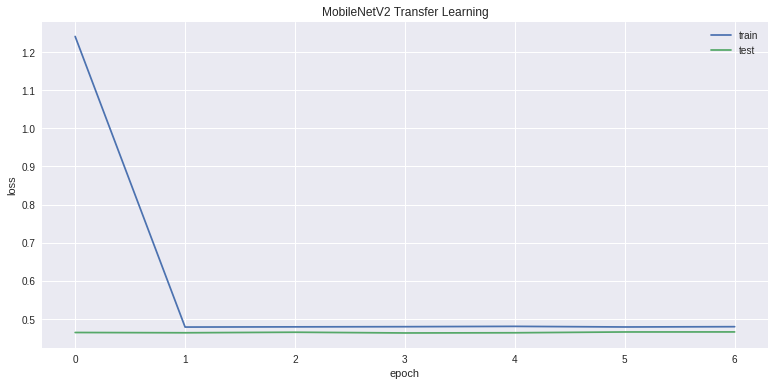

<Figure size 576x396 with 0 Axes>

In [15]:
# plotting the metrics
fig = plt.figure(figsize=(13,6))
plt.style.use('seaborn')
ax = plt.subplot(111)
ax.plot(history_cmplex_MovileNetV2.history['loss'])
ax.plot(history_cmplex_MovileNetV2.history['val_loss'])
ax.set_title('MobileNetV2 Transfer Learning')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)
plt.show()
plt.savefig('MobileNetV2 Transfer Learning.png',dpi=200)

In [16]:
model.save('results/MobileNetV2-edited.h5')

Loading Model

In [10]:
model = tf.keras.models.load_model('results/MobileNetV2-edited.h5')

Performance on Train Set

In [11]:
prediction = (model.predict(X_train_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

99/99 [==============================] - 14s 44ms/step


In [12]:
print(classification_report(prediction, y_train_arr))
print(confusion_matrix(prediction, y_train_arr))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3159
           1       0.00      0.00      0.00         0

    accuracy                           0.82      3159
   macro avg       0.50      0.41      0.45      3159
weighted avg       1.00      0.82      0.90      3159

[[2580  579]
 [   0    0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance on Test Set

In [11]:
prediction = (model.predict(X_test_arr)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

25/25 [==============================] - 9s 53ms/step


In [12]:
print(classification_report(prediction, y_test_arr))
print(confusion_matrix(prediction, y_test_arr))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90       790
           1       0.00      0.00      0.00         0

    accuracy                           0.83       790
   macro avg       0.50      0.41      0.45       790
weighted avg       1.00      0.83      0.90       790

[[652 138]
 [  0   0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# VGG19

In [9]:
from tensorflow.keras.applications import VGG19

In [10]:
X_train_arr_vgg, X_test_arr_vgg = tuple([tf.keras.applications.vgg19.preprocess_input(x) for x in [X_train_arr, X_test_arr]])


In [11]:
baseModel = VGG19(weights="imagenet", include_top=False,
	input_tensor = tfl.Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = tfl.MaxPooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = tfl.Dropout(0.1)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_vgg = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [13]:
model_vgg.compile(optimizer='adam',
              loss=
              'binary_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=1), 'accuracy'])

In [16]:
save_dir = "./results/"
model_name = 'VGG19-edited.h5'
model_path = os.path.join(save_dir, model_name)

history_cmplex_VGG19 = model_vgg.fit(X_train_arr_vgg, y_train_arr,
          batch_size=1,
          epochs=10,
          validation_data=(X_test_arr_vgg, y_test_arr),
          callbacks=[
            ModelCheckpoint(model_path, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=3, min_delta=0.0001)
          ])

Epoch 1/10
3159/3159 [==============================] - 68s 18ms/step - loss: 0.5117 - f1_score: 0.3098 - accuracy: 0.8107 - val_loss: 0.5051 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 2/10
3159/3159 [==============================] - 50s 16ms/step - loss: 0.4807 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4635 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 3/10
3159/3159 [==============================] - 50s 16ms/step - loss: 0.4777 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4635 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 4/10
3159/3159 [==============================] - 49s 16ms/step - loss: 0.4784 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4634 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 5/10
3159/3159 [==============================] - 49s 16ms/step - loss: 0.4775 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4635 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 6/10
3159/3159 [==============================] - 50s 

In [17]:
model_vgg.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

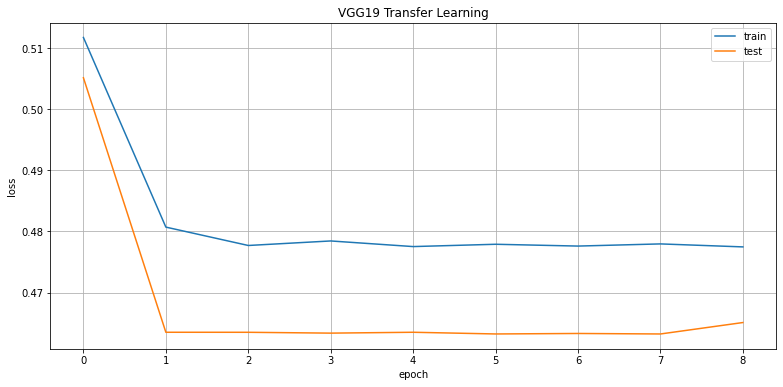

<Figure size 432x288 with 0 Axes>

In [18]:
# plotting the metrics
fig = plt.figure(figsize=(13,6))
ax = plt.subplot(111)
ax.plot(history_cmplex_VGG19.history['loss'])
ax.plot(history_cmplex_VGG19.history['val_loss'])
ax.set_title('VGG19 Transfer Learning')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)
plt.show()
plt.savefig('VGG19 Transfer Learning.png',dpi=200)

In [19]:
model_vgg.save('results/VGG19-edited.h5')

Loading Model

In [15]:
model_vgg = tf.keras.models.load_model('results/VGG19-edited.h5')

Performance on Train Set

In [16]:
prediction = (model_vgg.predict(X_train_arr_vgg)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

99/99 [==============================] - 31s 202ms/step


In [17]:
print(classification_report(prediction, y_train_arr))
print(confusion_matrix(prediction, y_train_arr))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3159
           1       0.00      0.00      0.00         0

    accuracy                           0.82      3159
   macro avg       0.50      0.41      0.45      3159
weighted avg       1.00      0.82      0.90      3159

[[2580  579]
 [   0    0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance on Test Set

In [18]:
prediction = (model_vgg.predict(X_test_arr_vgg)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

25/25 [==============================] - 7s 278ms/step


In [19]:
print(classification_report(prediction, y_test_arr))
print(confusion_matrix(prediction, y_test_arr))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90       790
           1       0.00      0.00      0.00         0

    accuracy                           0.83       790
   macro avg       0.50      0.41      0.45       790
weighted avg       1.00      0.83      0.90       790

[[652 138]
 [  0   0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# ResNet50

In [9]:
from tensorflow.keras.applications import ResNet50

In [10]:
X_train_arr_res, X_test_arr_res = tuple([tf.keras.applications.resnet50.preprocess_input(x) for x in [X_train_arr, X_test_arr]])


In [11]:
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor = tfl.Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = tfl.MaxPooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = tfl.Dropout(0.1)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_resnet = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [12]:
model_resnet.compile(optimizer='adam',
              loss=
              'binary_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=1), 'accuracy'])

In [13]:
save_dir = "./results/"
model_name = 'ResNet50-edited.h5'
model_path = os.path.join(save_dir, model_name)

history_cmplex_ResNet50 = model_resnet.fit(X_train_arr_res, y_train_arr,
          batch_size=1,
          epochs=50,
          validation_data=(X_test_arr_res, y_test_arr),
          callbacks=[
            ModelCheckpoint(model_path, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=3, min_delta=0.0001)
          ])

Epoch 1/50
3159/3159 [==============================] - 54s 14ms/step - loss: 0.5263 - f1_score: 0.3099 - accuracy: 0.8132 - val_loss: 0.4602 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 2/50
3159/3159 [==============================] - 41s 13ms/step - loss: 0.4803 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4633 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 3/50
3159/3159 [==============================] - 39s 12ms/step - loss: 0.4773 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4650 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 4/50
3159/3159 [==============================] - 43s 14ms/step - loss: 0.4775 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4633 - val_f1_score: 0.2974 - val_accuracy: 0.8253


In [14]:
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

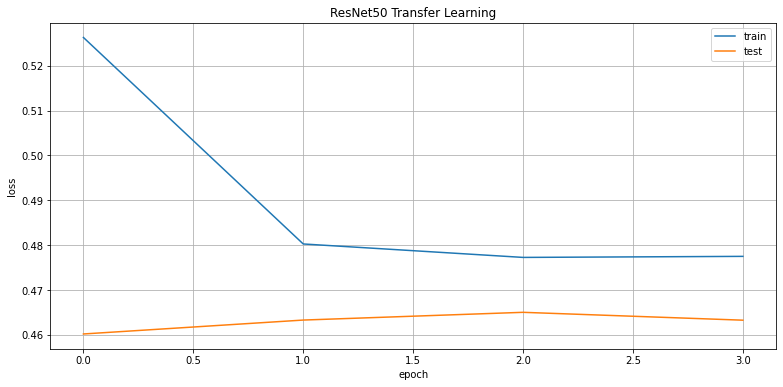

<Figure size 432x288 with 0 Axes>

In [15]:
# plotting the metrics
fig = plt.figure(figsize=(13,6))
ax = plt.subplot(111)
ax.plot(history_cmplex_ResNet50.history['loss'])
ax.plot(history_cmplex_ResNet50.history['val_loss'])
ax.set_title('ResNet50 Transfer Learning')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)
plt.show()
plt.savefig('ResNet50 Transfer Learning.png',dpi=200)

In [16]:
model_resnet.save('results/ResNet50-edited.h5')

Loading Model

In [11]:
model_resnet = tf.keras.models.load_model('results/ResNet50-edited.h5')

Performance on train Set

In [13]:
prediction = (model_resnet.predict(X_train_arr_res)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

99/99 [==============================] - 19s 101ms/step


In [14]:
print(classification_report(prediction, y_train_arr))
print(confusion_matrix(prediction, y_train_arr))

              precision    recall  f1-score   support

           0       1.00      0.82      0.90      3159
           1       0.00      0.00      0.00         0

    accuracy                           0.82      3159
   macro avg       0.50      0.41      0.45      3159
weighted avg       1.00      0.82      0.90      3159

[[2580  579]
 [   0    0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Performance on Test Set

In [12]:
prediction = (model_resnet.predict(X_test_arr_res)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

25/25 [==============================] - 13s 117ms/step


In [13]:
print(classification_report(prediction, y_test_arr))
print(confusion_matrix(prediction, y_test_arr))

              precision    recall  f1-score   support

           0       1.00      0.83      0.90       790
           1       0.00      0.00      0.00         0

    accuracy                           0.83       790
   macro avg       0.50      0.41      0.45       790
weighted avg       1.00      0.83      0.90       790

[[652 138]
 [  0   0]]


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# InceptionV3

In [9]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [10]:
X_train_arr_incep, X_test_arr_incep = tuple([tf.keras.applications.inception_v3.preprocess_input(x) for x in [X_train_arr, X_test_arr]])


In [11]:
baseModel = InceptionV3(weights="imagenet", include_top=False,
	input_tensor = tfl.Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = tfl.MaxPooling2D(pool_size=(3, 3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = tfl.Dropout(0.1)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model_inception = tf.keras.models.Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

87910968/87910968 [==============================] - 0s 0us/step


In [12]:
model_inception.compile(optimizer='adam',
              loss=
              'binary_crossentropy',
              metrics=[tfa.metrics.F1Score(num_classes=1), 'accuracy'])

In [13]:
save_dir = "./results/"
model_name = 'InceptionV3-edited.h5'
model_path = os.path.join(save_dir, model_name)

history_cmplex_InceptionV3 = model_inception.fit(X_train_arr_incep, y_train_arr,
          batch_size=1,
          epochs=50,
          validation_data=(X_test_arr_incep, y_test_arr),
          callbacks=[
            ModelCheckpoint(model_path, save_best_only=True),
            EarlyStopping(monitor='val_loss', mode='min', patience=3, min_delta=0.0001)
          ])

Epoch 1/50
3159/3159 [==============================] - 345s 108ms/step - loss: 0.4804 - f1_score: 0.3098 - accuracy: 0.8154 - val_loss: 0.4188 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 2/50
3159/3159 [==============================] - 336s 106ms/step - loss: 0.4210 - f1_score: 0.3098 - accuracy: 0.8164 - val_loss: 0.4325 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 3/50
3159/3159 [==============================] - 336s 106ms/step - loss: 0.3858 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.4054 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 4/50
3159/3159 [==============================] - 337s 107ms/step - loss: 0.3687 - f1_score: 0.3098 - accuracy: 0.8167 - val_loss: 0.3244 - val_f1_score: 0.2974 - val_accuracy: 0.8253
Epoch 5/50
3159/3159 [==============================] - 335s 106ms/step - loss: 0.3636 - f1_score: 0.3098 - accuracy: 0.8177 - val_loss: 0.3134 - val_f1_score: 0.2977 - val_accuracy: 0.8253
Epoch 6/50
3159/3159 [============================

In [14]:
model_inception.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

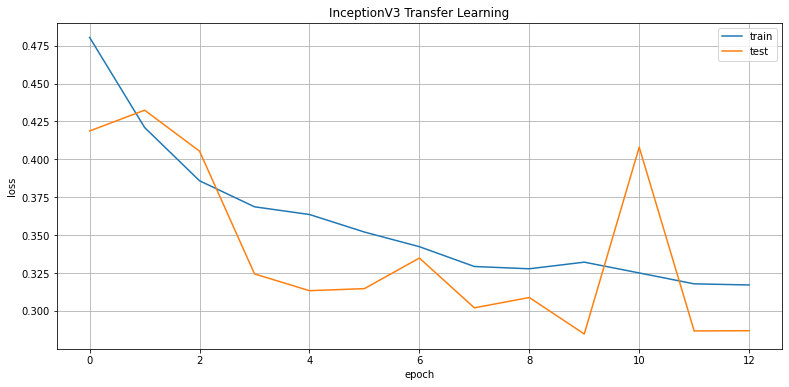

<Figure size 432x288 with 0 Axes>

In [15]:
# plotting the metrics
fig = plt.figure(figsize=(13,6))
ax = plt.subplot(111)
ax.plot(history_cmplex_InceptionV3.history['loss'])
ax.plot(history_cmplex_InceptionV3.history['val_loss'])
ax.set_title('InceptionV3 Transfer Learning')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper right')
ax.grid(True)
plt.show()
plt.savefig('InceptionV3 Transfer Learning.png',dpi=200)

In [16]:
model_inception.save('results/InceptionV3-edited.h5')

Loading Model

In [17]:
tf.keras.models.load_model('results/InceptionV3-edited.h5')

Performance on Train Set

In [18]:
prediction = (model_inception.predict(X_train_arr_incep)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

99/99 [==============================] - 222s 2s/step


In [19]:
print(classification_report(prediction, y_train_arr))
print(confusion_matrix(prediction, y_train_arr))

              precision    recall  f1-score   support

           0       0.92      0.91      0.91      2592
           1       0.60      0.62      0.61       567

    accuracy                           0.86      3159
   macro avg       0.76      0.76      0.76      3159
weighted avg       0.86      0.86      0.86      3159

[[2363  229]
 [ 217  350]]


Performance on Test Set

In [20]:
prediction = (model_inception.predict(X_test_arr_incep)).squeeze()
prediction = np.where(prediction>=0.5 , 1 , 0)

25/25 [==============================] - 55s 2s/step


In [21]:
print(classification_report(prediction, y_test_arr))
print(confusion_matrix(prediction, y_test_arr))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       639
           1       0.57      0.52      0.54       151

    accuracy                           0.83       790
   macro avg       0.73      0.71      0.72       790
weighted avg       0.83      0.83      0.83       790

[[579  60]
 [ 73  78]]
